## Вариант 1

**Цель:** Контроль дисперсии весов.

- Разработайте архитектуру, которая будет за **5 слоев** приводить тензор к размерности `(1, 512, 1, 1)`.
- **Условие:** дисперсия весов третьего слоя должна быть в **два раза больше**, чем у второго и четвертого.
- **Эксперимент:** Проверьте влияние увеличенной дисперсии третьего слоя на распределение активаций после GAP и визуализируйте их гистограмму.


In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch


from torchvision import datasets, transforms

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.init import calculate_gain

class VarianceControlledNet(nn.Module):
    def __init__(self, input_channels=3, target_channels=512):
        super(VarianceControlledNet, self).__init__()
        
        self.conv1 = nn.Conv2d(input_channels, 256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(384, 448, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(448, 512, kernel_size=3, padding=1)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self._initialize_weights()
    
    def _initialize_weights(self):
        base_scale = 0.1
        
        # Слой 1
        nn.init.normal_(self.conv1.weight, mean=0, std=base_scale)
        nn.init.constant_(self.conv1.bias, 0)
        
        # Слой 2
        nn.init.normal_(self.conv2.weight, mean=0, std=base_scale)
        nn.init.constant_(self.conv2.bias, 0)
        
        # Слой 3
        nn.init.normal_(self.conv3.weight, mean=0, std=base_scale * np.sqrt(2))
        nn.init.constant_(self.conv3.bias, 0)
        
        # Слой 4
        nn.init.normal_(self.conv4.weight, mean=0, std=base_scale)
        nn.init.constant_(self.conv4.bias, 0)
        
        print("Инициализация весов завершена")
        self._verify_variances()
    
    def _verify_variances(self):
        """Проверка соотношения дисперсий"""
        var_conv2 = torch.var(self.conv2.weight).item()
        var_conv3 = torch.var(self.conv3.weight).item()
        var_conv4 = torch.var(self.conv4.weight).item()
        
        ratio_3_to_2 = var_conv3 / var_conv2
        ratio_3_to_4 = var_conv3 / var_conv4
        
        print(f"Дисперсия весов:")
        print(f"Слой 2: {var_conv2:.6f}")
        print(f"Слой 3: {var_conv3:.6f}")
        print(f"Слой 4: {var_conv4:.6f}")
        print(f"Отношение дисперсий слой3/слой2: {ratio_3_to_2:.3f}")
        print(f"Отношение дисперсий слой3/слой4: {ratio_3_to_4:.3f}")
        
        return ratio_3_to_2, ratio_3_to_4
    
    def forward(self, x):
        activations = {}
        
        x = F.relu(self.conv1(x))
        activations['after_conv1'] = x
        
        x = F.relu(self.conv2(x))
        activations['after_conv2'] = x
        
        x = F.relu(self.conv3(x))
        activations['after_conv3'] = x
        
        x = F.relu(self.conv4(x))
        activations['after_conv4'] = x
        
        # Global Average Pooling
        x = self.gap(x)
        activations['after_gap'] = x
        
        return x, activations

In [3]:
model = VarianceControlledNet()

Инициализация весов завершена
Дисперсия весов:
Слой 2: 0.009994
Слой 3: 0.019944
Слой 4: 0.009987
Отношение дисперсий слой3/слой2: 1.996
Отношение дисперсий слой3/слой4: 1.997


In [4]:
pred, activations = model(torch.randn(1, 3, 32, 32))
print(pred.shape)

_ = model._verify_variances()

torch.Size([1, 512, 1, 1])
Дисперсия весов:
Слой 2: 0.009994
Слой 3: 0.019944
Слой 4: 0.009987
Отношение дисперсий слой3/слой2: 1.996
Отношение дисперсий слой3/слой4: 1.997


Инициализация весов завершена
Дисперсия весов:
Слой 2: 0.009998
Слой 3: 0.020019
Слой 4: 0.010011
Отношение дисперсий слой3/слой2: 2.002
Отношение дисперсий слой3/слой4: 2.000

Входной тензор: torch.Size([64, 3, 32, 32])
Выходной тензор: torch.Size([64, 512, 1, 1])

Статистика активаций после GAP:
Среднее: 16.7735
Стандартное отклонение: 16.5557
Минимум: 0.0000
Максимум: 88.6621


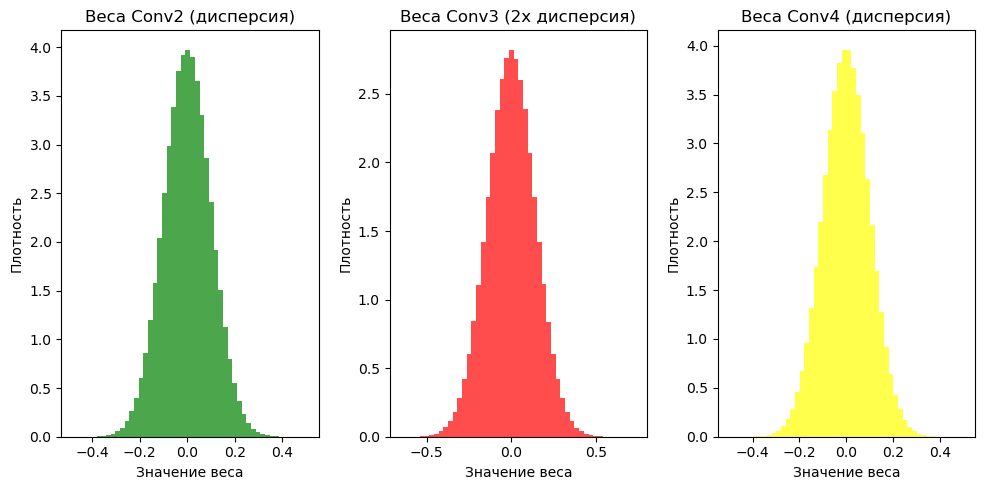

In [15]:
def run_experiment():
    model = VarianceControlledNet(input_channels=3, target_channels=512)
    
    batch_size = 64
    input_tensor = torch.randn(batch_size, 3, 32, 32)
    
    output, activations = model(input_tensor)
    
    print(f"\nВходной тензор: {input_tensor.shape}")
    print(f"Выходной тензор: {output.shape}")
    
    gap_activations = activations['after_gap'].detach().flatten().numpy()
    
    print(f"\nСтатистика активаций после GAP:")
    print(f"Среднее: {np.mean(gap_activations):.4f}")
    print(f"Стандартное отклонение: {np.std(gap_activations):.4f}")
    print(f"Минимум: {np.min(gap_activations):.4f}")
    print(f"Максимум: {np.max(gap_activations):.4f}")
    

    fig, axes = plt.subplots(1,3, figsize=(10, 5))
    
    weights_conv2 = model.conv2.weight.detach().flatten().numpy()
    axes[0].hist(weights_conv2, bins=50, alpha=0.7, color='green', density=True)
    axes[0].set_title('Веса Conv2 (дисперсия)')
    axes[0].set_xlabel('Значение веса')
    axes[0].set_ylabel('Плотность')

    # Гистограмма весов третьего слоя
    weights_conv3 = model.conv3.weight.detach().flatten().numpy()
    axes[1].hist(weights_conv3, bins=50, alpha=0.7, color='red', density=True)
    axes[1].set_title('Веса Conv3 (2x дисперсия)')
    axes[1].set_xlabel('Значение веса')
    axes[1].set_ylabel('Плотность')

    weights_conv4 = model.conv4.weight.detach().flatten().numpy()
    axes[2].hist(weights_conv4, bins=50, alpha=0.7, color='yellow', density=True)
    axes[2].set_title('Веса Conv4 (дисперсия)')
    axes[2].set_xlabel('Значение веса')
    axes[2].set_ylabel('Плотность')
    
    plt.tight_layout()
    plt.show()
    
    return model, activations

# Запуск эксперимента
model, activations = run_experiment()

In [16]:
def analyze_activation_statistics(activations):
    print("\n" + "="*50)
    print("ДЕТАЛЬНЫЙ АНАЛИЗ АКТИВАЦИЙ")
    print("="*50)
    
    layers = ['after_conv1', 'after_conv2', 'after_conv3', 'after_conv4', 'after_gap']
    titles = ['После Conv1', 'После Conv2', 'После Conv3', 'После Conv4', 'После GAP']
    
    for layer, title in zip(layers, titles):
        act = activations[layer].detach()
        flat_act = act.flatten()
        
        print(f"\n{title}:")
        print(f"  Форма: {act.shape}")
        print(f"  Среднее: {flat_act.mean():.6f}")
        print(f"  Стандартное отклонение: {flat_act.std():.6f}")
        print(f"  Дисперсия: {flat_act.var():.6f}")
        print(f"  Минимум: {flat_act.min():.6f}")
        print(f"  Максимум: {flat_act.max():.6f}")
analyze_activation_statistics(activations)


ДЕТАЛЬНЫЙ АНАЛИЗ АКТИВАЦИЙ

После Conv1:
  Форма: torch.Size([64, 256, 32, 32])
  Среднее: 0.200624
  Стандартное отклонение: 0.298305
  Дисперсия: 0.088986
  Минимум: 0.000000
  Максимум: 2.974762

После Conv2:
  Форма: torch.Size([64, 384, 32, 32])
  Среднее: 0.673605
  Стандартное отклонение: 0.988595
  Дисперсия: 0.977320
  Минимум: 0.000000
  Максимум: 11.716281

После Conv3:
  Форма: torch.Size([64, 448, 32, 32])
  Среднее: 3.713103
  Стандартное отклонение: 5.679628
  Дисперсия: 32.258171
  Минимум: 0.000000
  Максимум: 58.969028

После Conv4:
  Форма: torch.Size([64, 512, 32, 32])
  Среднее: 16.773487
  Стандартное отклонение: 24.577805
  Дисперсия: 604.068542
  Минимум: 0.000000
  Максимум: 224.886780

После GAP:
  Форма: torch.Size([64, 512, 1, 1])
  Среднее: 16.773485
  Стандартное отклонение: 16.555908
  Дисперсия: 274.098083
  Минимум: 0.000000
  Максимум: 88.662064
